In [13]:
import pandas as pd
import numpy as np
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = pd.read_csv('..\\..\\Dataset\\testes\\dataset_casos_mensais_publicacao.csv', 
                    parse_dates=['dt_notificacao'],
                    usecols=['dt_notificacao', 'cd_municipio', 'qntd_casos', 'temp_media_mensal']
                )
df = df.sort_values('dt_notificacao')

df_sp = df[(df['cd_municipio'] == 355030) & (df['dt_notificacao'] >= '2018-01-01') & (df['dt_notificacao'] <= '2023-12-01')]


C:\Users\kenzo\AppData\Local\Temp\ipykernel_16400\4277937555.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sp.fillna(method='ffill', inplace=True)
C:\Users\kenzo\AppData\Local\Temp\ipykernel_16400\4277937555.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sp.fillna(method='ffill', inplace=True)
C:\Users\kenzo\AppData\Local\Temp\ipykernel_16400\4277937555.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_sp.resample('M').mean().plot(subplots=True)
C:\Users\kenzo\AppData\Local\Temp\ipykernel_16400\4277937555.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_sp = df_sp.resample('M'

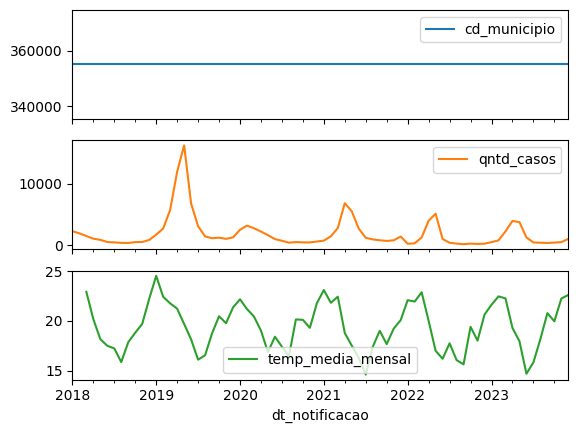

In [14]:
# Set the date column as the index
df_sp.set_index('dt_notificacao', inplace=True)

# Handling missing values
df_sp.fillna(method='ffill', inplace=True)

df_sp.resample('M').mean().plot(subplots=True)

df_sp = df_sp.resample('M').mean()

In [15]:
# Split the dataset into training and testing
train_size = int(len(df_sp) * 0.8)
train = df_sp.iloc[:train_size]
test = df_sp.iloc[train_size:]

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1017.666, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1016.905, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1014.508, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1015.694, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1012.865, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1014.412, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1014.641, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1013.820, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1015.469, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1006.693, Time=0.28 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=1008.273, Time=0.68 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept

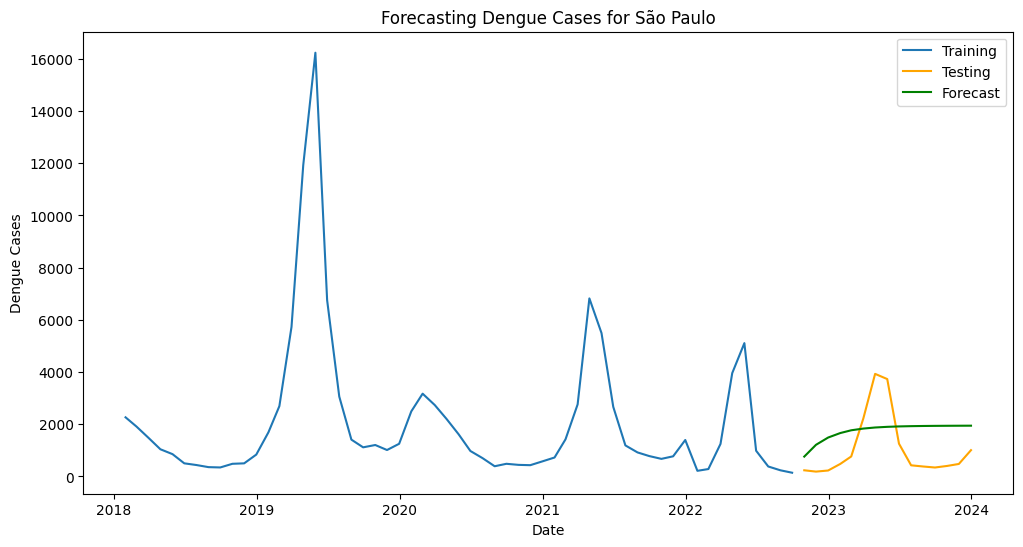

Root Mean Squared Error (RMSE): 1319.0655279267692


In [16]:
# Set the target variable (dengue cases) and exogenous variables (temperature)
y_train = train['qntd_casos']
y_test = test['qntd_casos']
exog_train = train[['temp_media_mensal']]
exog_test = test[['temp_media_mensal']]

# Initialize the auto_arima model
model = pm.auto_arima(
    y_train,
    #exogenous=exog_train,
    seasonal=True,
    m=12,  # Seasonality (monthly data)
    start_p=0, start_q=0,
    #max_order=4,
    max_p=3, max_q=3,
    d=None,  # Automatically determine the order of differencing
    test='adf',  # Augmented Dickey-Fuller test for stationarity
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Fit the model
model.fit(y_train)#exogenous=exog_train)

# Forecast
n_periods = len(y_test)
forecast = model.predict(n_periods=n_periods) #exogenous=exog_test)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, y_train, label='Training')
plt.plot(test.index, y_test, label='Testing', color='orange')
plt.plot(test.index, forecast, label='Forecast', color='green')
plt.title(f'Forecasting Dengue Cases for São Paulo')
plt.xlabel('Date')
plt.ylabel('Dengue Cases')
plt.legend()
plt.show()

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, forecast))
print(f'Root Mean Squared Error (RMSE): {rmse}')
